<span style="font-family: 'Times New Roman'; font-size: 18px;">Основными методами решения задач с табличными данными являются решения на основании деревьев, в частности, градиентный бустинг. Поэтому в качестве безлайна, с которым будем сравнивать DL решения, будем использовать Catboost.</span>

In [2]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from catboost import CatBoostClassifier
from sklearn.metrics import (balanced_accuracy_score,
                             classification_report,
                             confusion_matrix,
                             f1_score, roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [3]:
allowed_nans = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN',
                '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NA',
                'NULL', 'NaN', 'n/a', 'nan', 'null']
data = pd.read_csv("../data/processed/processed_data.csv",
                   na_values=allowed_nans, keep_default_na=False)

<span style="font-family: 'Times New Roman'; font-size: 18px;">Как уже было показано в части EDA, данные имеют сильный дисбаланс классов, поэтому требуются некоторые дополнения для эффективного обучения и правильного замера качества модели:</span>
1. <span style="font-family: 'Times New Roman'; font-size: 17px;">В качестве метрик будем использовать метрики устойчивые к дисбалансу классов, а именно, balanced accuracy, weighted f1, ovo macro roc auc</span>
2. <span style="font-family: 'Times New Roman'; font-size: 17px;">Кроме того, требуется внести некоторые дополнения к процессу обучения, чтобы улучшить качество модели:</span>
   * <span style="font-family: 'Times New Roman'; font-size: 16px;">Undersampling (pytorch WeightedRandomSampler)</span>
   * <span style="font-family: 'Times New Roman'; font-size: 16px;">Oversampling ([SMOTE](https://arxiv.org/pdf/1106.1813))</span>
   * <span style="font-family: 'Times New Roman'; font-size: 16px;">Функции потерь, более устойчивые к дисбалансу классов ([Focal loss](https://arxiv.org/pdf/1708.02002v2))</span>
   * <span style="font-family: 'Times New Roman'; font-size: 16px;">Class Weighting</span>
   
   <span style="font-family: 'Times New Roman'; font-size: 17px;">На предварительных тестах Class Weighting показал себя наиболее эффективно, поэтому далее будем иcпользовать его</span>

In [4]:
train_ratio = 0.9
validation_ratio = 0.06
test_ratio = 0.04

columns = data.columns
num_columns = data._get_numeric_data().columns
categorical_features = list(set(columns) - set(num_columns))
categorical_features.remove('health')
categorical_features.append('block_id')
categorical_features.append("postcode")
categorical_features.append("st_senate")
categorical_features.append("census tract")
categorical_features.append("created_month")
categorical_features.append("cluster_label")

columns = list(columns)
columns.remove('health')
columns.remove('Unnamed: 0')

X = data[list(columns)]
y = data['health']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=1 - train_ratio,
                                                    random_state=42,
                                                    stratify=y)
test_size = test_ratio/(test_ratio + validation_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,
                                                test_size=test_size,
                                                stratify=y_test) 

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Val shape: {X_val.shape}")

Train shape: (586953, 35)
Test shape: (26088, 35)
Val shape: (39130, 35)


In [5]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced',
                               classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

model = CatBoostClassifier(
    iterations=1000,
    random_seed=42,
    verbose=1,
    class_weights=class_weights
)

In [6]:
model.fit(X_train, y_train, cat_features=categorical_features)

y_pred = model.predict(X_test)

accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Baseline Model Accuracy: {accuracy:.4f}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Baseline Model f1: {f1:.4f}")

roc = roc_auc_score(y_test, model.predict_proba(X_test),
                    multi_class='ovo', average='macro')
print(f"Baseline Model roc_auc_score: {roc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Learning rate set to 0.109527
0:	learn: 1.0618295	total: 4.84s	remaining: 1h 20m 40s
1:	learn: 1.0325097	total: 9.33s	remaining: 1h 17m 34s
2:	learn: 1.0090160	total: 13.7s	remaining: 1h 15m 50s
3:	learn: 0.9893992	total: 18.7s	remaining: 1h 17m 37s
4:	learn: 0.9736335	total: 23s	remaining: 1h 16m 16s
5:	learn: 0.9611146	total: 27.1s	remaining: 1h 14m 43s
6:	learn: 0.9504756	total: 31s	remaining: 1h 13m 19s
7:	learn: 0.9382985	total: 35.3s	remaining: 1h 13m
8:	learn: 0.9262219	total: 39.5s	remaining: 1h 12m 26s
9:	learn: 0.9183672	total: 43.9s	remaining: 1h 12m 25s
10:	learn: 0.9111926	total: 48.4s	remaining: 1h 12m 33s
11:	learn: 0.9048133	total: 52.8s	remaining: 1h 12m 28s
12:	learn: 0.8978429	total: 56.7s	remaining: 1h 11m 45s
13:	learn: 0.8914742	total: 1m	remaining: 1h 11m 22s
14:	learn: 0.8828123	total: 1m 4s	remaining: 1h 10m 25s
15:	learn: 0.8772130	total: 1m 8s	remaining: 1h 9m 53s
16:	learn: 0.8712567	total: 1m 11s	remaining: 1h 9m 15s
17:	learn: 0.8662888	total: 1m 15s	remai

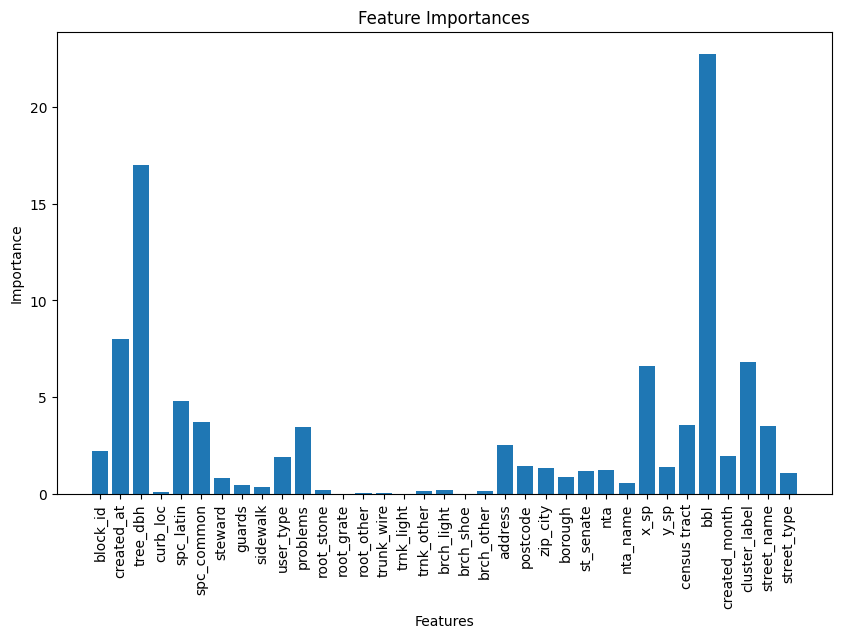

In [7]:
names = model.feature_names_
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), model.feature_importances_)
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

<span style="font-family: 'Times New Roman'; font-size: 18px;">По скольку данные не имеют никакой специальной структуры, архитектура модели преимущественно будет состоят из линейных слоев.
Все категориальные признаки и некоторые числовые признаки, которые по смыслу являются категориальными, будем обратывать с помощью эмбеддинг слоев. Остальную архитектуру будем строить по принципу линейный слой -> нормализация -> функция активации -> дропаут.</span>

In [31]:
class TreeHealthDataset(Dataset):
    def __init__(self, encoded_categorical_data,
                 numerical_tensor,
                 encoded_health):
        self.categorical_data = encoded_categorical_data
        self.numerical_data = numerical_tensor
        self.labels = encoded_health
        self.feature_names = list(encoded_categorical_data.keys())

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        categorical_features = {
            name: data[idx]
            for name, data in self.categorical_data.items()
        }
        numerical_feature = self.numerical_data[idx]
        label = self.labels[idx]
        return categorical_features, label, numerical_feature

In [32]:
categorical_cols_names = ['street_type', 'zip_city', 'root_grate',
                          'brch_other', 'steward', 'root_other', 'sidewalk',
                          'trunk_wire', 'created_at', 'curb_loc',
                          'street_name', 'borough', 'nta_name',
                          'root_stone', 'problems', 'brch_light',
                          'brch_shoe', 'guards', 'spc_common',
                          'nta', 'user_type', 'trnk_light', 'trnk_other',
                          'spc_latin', 'block_id', 'postcode', 'st_senate',
                          'census tract', 'created_month', 'cluster_label']
numerical_cols_names = [
    col
    for col in data.columns
    if col not in categorical_cols_names
]
numerical_cols_names.remove('Unnamed: 0')
numerical_cols_names.remove('address')
numerical_cols_names.remove('health')


health_labels_unique = sorted(list(set(data['health'])))
health_label_to_index = {
    label: index
    for index, label in enumerate(health_labels_unique)
}

datasets = {}
embedding_dims = {}
encoded_health_train = None
label_encoderes = {}

for col in categorical_cols_names:
    le = LabelEncoder()
    label_encoderes[col] = le.fit(pd.concat([X_train, X_val, X_test])[col])

joblib.dump(label_encoderes, 'label_encoders.joblib')

for features_data, target_data, dataset_name in \
        [(X_train.copy(), y_train.copy(), "train"),
         (X_val.copy(), y_val.copy(), "val"),
         (X_test.copy(), y_test.copy(), "test")]:
    encoded_categorical_data = {}
    for col in categorical_cols_names:
        features_data[col] = label_encoderes[col].transform(features_data[col])
        encoded_categorical_data[col] = torch.tensor(features_data[col].values,
                                                     dtype=torch.long)
        num_unique_categories = len(label_encoderes[col].classes_)
        if dataset_name == 'train':
            embedding_dim = min(50, (num_unique_categories + 1) // 2)
            embedding_dims[col] = (num_unique_categories, embedding_dim)

    numerical_data = features_data[numerical_cols_names].copy()
    scaler = StandardScaler()
    scaled_numerical_data = scaler.fit_transform(numerical_data)
    joblib.dump(scaler, f'numerical_scaler_{dataset_name}.joblib')
    numerical_tensor = torch.tensor(scaled_numerical_data, dtype=torch.float32)

    encoded_health = torch.tensor([
        health_label_to_index[label]
        for label in target_data
    ])

    if dataset_name == 'train':
        encoded_health_train = encoded_health
    
    dataset = TreeHealthDataset(encoded_categorical_data,
                                numerical_tensor, encoded_health)
    datasets[dataset_name] = dataset


joblib.dump(categorical_cols_names, 'categorical_cols_names.joblib')
joblib.dump(numerical_cols_names, 'numerical_cols_names.joblib')

['numerical_cols_names.joblib']

In [37]:
batch_size = 4096
train_loader = DataLoader(datasets['train'],
                          batch_size=batch_size, shuffle=True)
val_loader = DataLoader(datasets['val'],
                        batch_size=batch_size, shuffle=False)
test_loader = DataLoader(datasets['test'],
                         batch_size=batch_size, shuffle=False)

In [38]:
class SimpleTreeHealthModel(nn.Module):
    """Простая модель нейронной сети для классификации состояния деревьев."""

    def __init__(self, embedding_dims, num_classes, num_dim):
        """
        Инициализация слоев модели.

        Args:
            embedding_dims (dict): Словарь, содержащий
             размеры embedding слоев для категориальных признаков.
                                     Ключи - имена категориальных признаков,
                                     значения - кортежи:
                                     (количество уникальных значений,
                                     размерность эмбеддинга).
            num_classes (int): Количество классов для классификации.
            num_dim (int): Размерность входных числовых данных.
        """
        super().__init__()
        self.embedding_layers = nn.ModuleDict(
            {
                name: nn.Embedding(num_embed, embed_dim)
                for name, (num_embed, embed_dim) in embedding_dims.items()
            }
        )
        embedding_output_dim = sum(dims[1] for dims in embedding_dims.values())

        self.cat_seq = nn.Sequential(
            nn.Linear(embedding_output_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        self.num_seq = nn.Sequential(
            nn.Linear(num_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

        self.final_seq = nn.Sequential(
            nn.Linear(1024 + 64, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes),
        )

    def forward(self, categorical_data, numerical_data):
        """
        Прямой проход модели.

        Args:
            categorical_data (dict): Словарь с категориальными данными.
                                      Ключи - имена категориальных признаков,
                                      значения - тензоры индексов.
            numerical_data (torch.Tensor): Тензор числовых данных.

        Returns:
            torch.Tensor: Выход модели - логиты классов.
        """
        numerical_output = self.num_seq(numerical_data)
        cat_embeddings = []
        for name, data in categorical_data.items():
            cat_embeddings.append(self.embedding_layers[name](data))
        combined_cat_embeddings = torch.cat(cat_embeddings, dim=1)
        categorical_output = self.cat_seq(combined_cat_embeddings)

        combined_features = torch.cat([numerical_output, categorical_output],
                                      dim=1)
        return self.final_seq(combined_features)

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = len(health_labels_unique)
model = SimpleTreeHealthModel(embedding_dims,
                              num_classes, len(datasets['train'][0][2]))
model.to(device)

class_weights = compute_class_weight('balanced',
                                     classes=np.unique(encoded_health_train),
                                     y=encoded_health_train.numpy())
class_weights_tensor = torch.tensor(class_weights,
                                    dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=0.0003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
num_epochs = 30

In [40]:
def plots(train_losses,
          val_losses,
          val_accuracies,
          val_f1_scores,
          val_auc_rocs):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.title('График Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Balanced Accuracy')
    plt.plot(val_f1_scores, label='Validation Weighted F1-Score')
    plt.plot(val_auc_rocs, label='Validation Macro AUC-ROC')
    plt.xlabel('Эпоха')
    plt.ylabel('Метрика')
    plt.title('График Метрик Валидации')
    plt.legend()

    plt.tight_layout()
    plt.show()

    conf_matrix = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(all_labels),
                yticklabels=np.unique(all_labels))
    plt.ylabel('Истинные метки')
    plt.xlabel('Предсказанные метки')
    plt.title(f'Confusion Matrix - Эпоха {epoch+1}')
    plt.show()

    class_report = classification_report(all_labels, all_predictions)
    print("Classification Report:\n", class_report)

Эпоха 1/30 (Валидация): 100%|██████████| 10/10 [00:06<00:00,  1.66it/s, val_loss=0.959]



Эпоха: 1/30
Train Loss: 1.0097
Validation Loss: 0.9602
Validation Balanced Accuracy: 0.5130
Validation Weighted F1-Score: 0.6268
Validation Macro AUC-ROC: 0.7079

Модель улучшена и сохранена! (Validation Loss: 0.9602, Эпоха: 1)



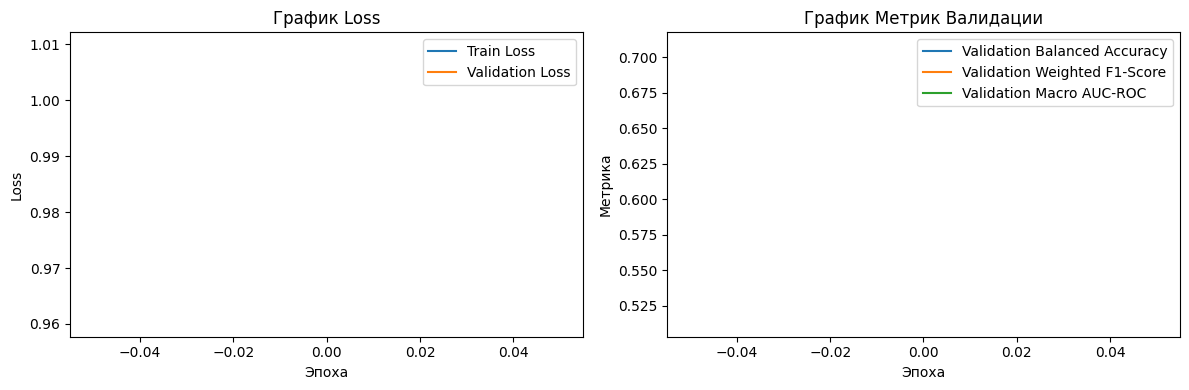

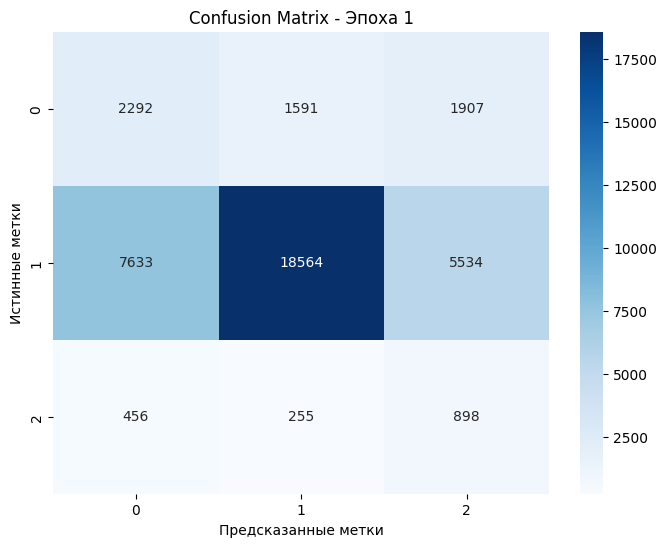

Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.40      0.28      5790
           1       0.91      0.59      0.71     31731
           2       0.11      0.56      0.18      1609

    accuracy                           0.56     39130
   macro avg       0.41      0.51      0.39     39130
weighted avg       0.77      0.56      0.63     39130



Эпоха 2/30 (Валидация): 100%|██████████| 10/10 [00:06<00:00,  1.62it/s, val_loss=0.963]



Эпоха: 2/30
Train Loss: 0.9581
Validation Loss: 0.9457
Validation Balanced Accuracy: 0.5289
Validation Weighted F1-Score: 0.6385
Validation Macro AUC-ROC: 0.7214

Модель улучшена и сохранена! (Validation Loss: 0.9457, Эпоха: 2)



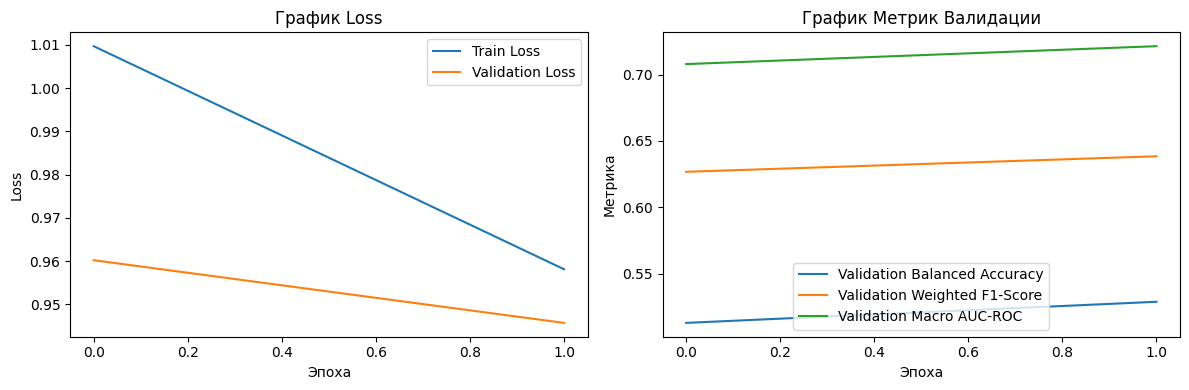

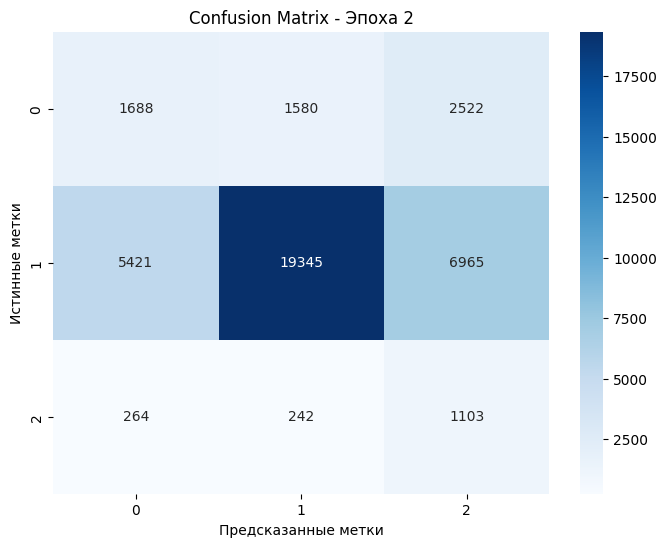

Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.29      0.26      5790
           1       0.91      0.61      0.73     31731
           2       0.10      0.69      0.18      1609

    accuracy                           0.57     39130
   macro avg       0.42      0.53      0.39     39130
weighted avg       0.78      0.57      0.64     39130



Эпоха 3/30 (Валидация): 100%|██████████| 10/10 [00:05<00:00,  1.68it/s, val_loss=0.927]



Эпоха: 3/30
Train Loss: 0.9400
Validation Loss: 0.9287
Validation Balanced Accuracy: 0.5366
Validation Weighted F1-Score: 0.6531
Validation Macro AUC-ROC: 0.7312

Модель улучшена и сохранена! (Validation Loss: 0.9287, Эпоха: 3)



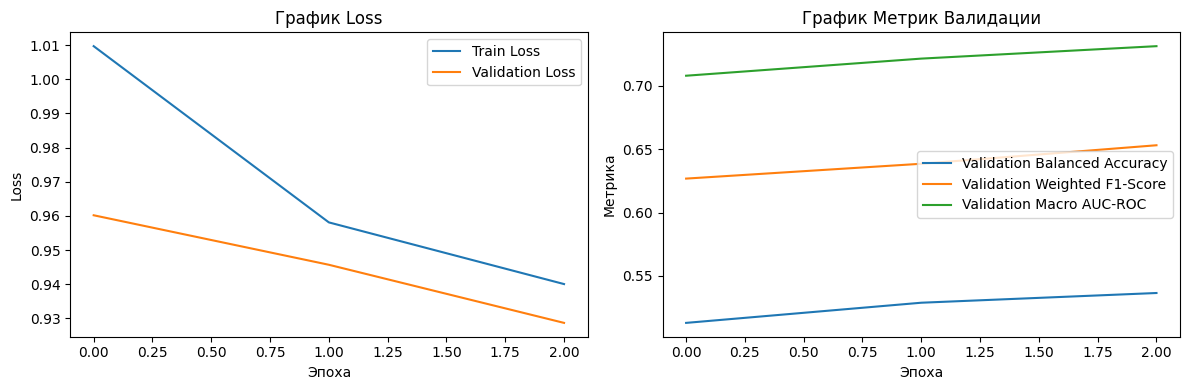

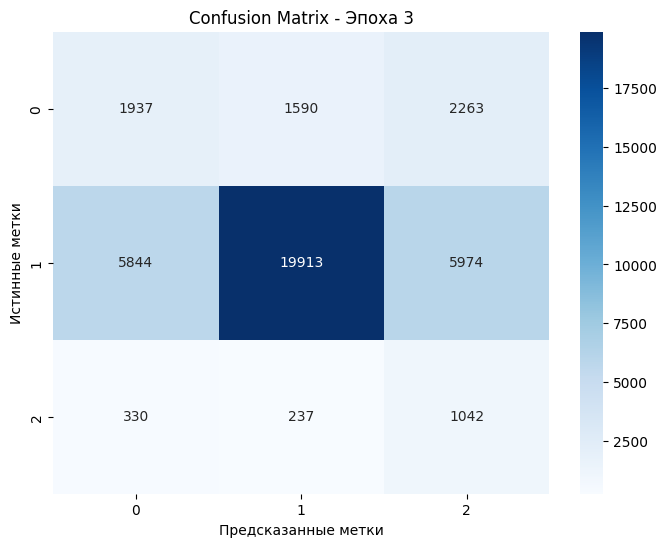

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.33      0.28      5790
           1       0.92      0.63      0.74     31731
           2       0.11      0.65      0.19      1609

    accuracy                           0.59     39130
   macro avg       0.42      0.54      0.40     39130
weighted avg       0.78      0.59      0.65     39130



Эпоха 4/30 (Валидация): 100%|██████████| 10/10 [00:06<00:00,  1.65it/s, val_loss=0.907]



Эпоха: 4/30
Train Loss: 0.9109
Validation Loss: 0.9121
Validation Balanced Accuracy: 0.5514
Validation Weighted F1-Score: 0.6634
Validation Macro AUC-ROC: 0.7441

Модель улучшена и сохранена! (Validation Loss: 0.9121, Эпоха: 4)



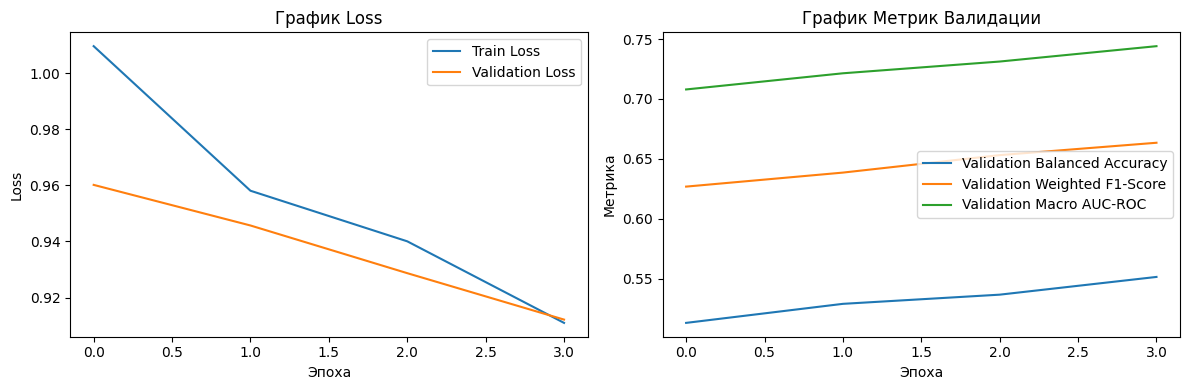

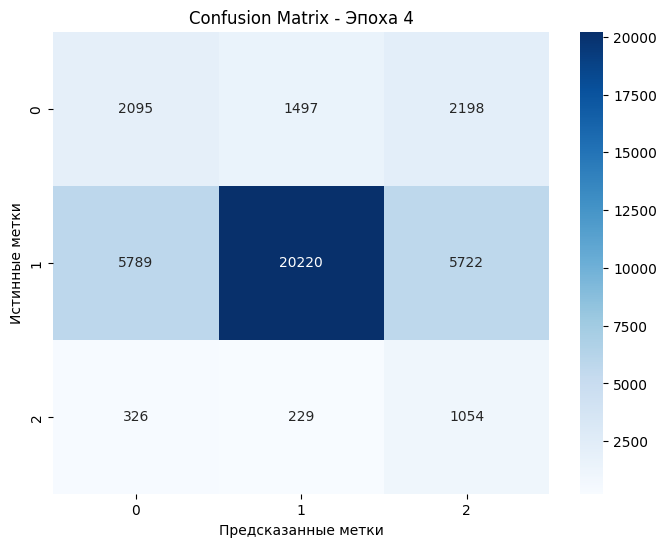

Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.36      0.30      5790
           1       0.92      0.64      0.75     31731
           2       0.12      0.66      0.20      1609

    accuracy                           0.60     39130
   macro avg       0.43      0.55      0.42     39130
weighted avg       0.79      0.60      0.66     39130



Эпоха 5/30 (Валидация): 100%|██████████| 10/10 [00:06<00:00,  1.66it/s, val_loss=0.899]



Эпоха: 5/30
Train Loss: 0.8979
Validation Loss: 0.9040
Validation Balanced Accuracy: 0.5589
Validation Weighted F1-Score: 0.7019
Validation Macro AUC-ROC: 0.7499

Модель улучшена и сохранена! (Validation Loss: 0.9040, Эпоха: 5)



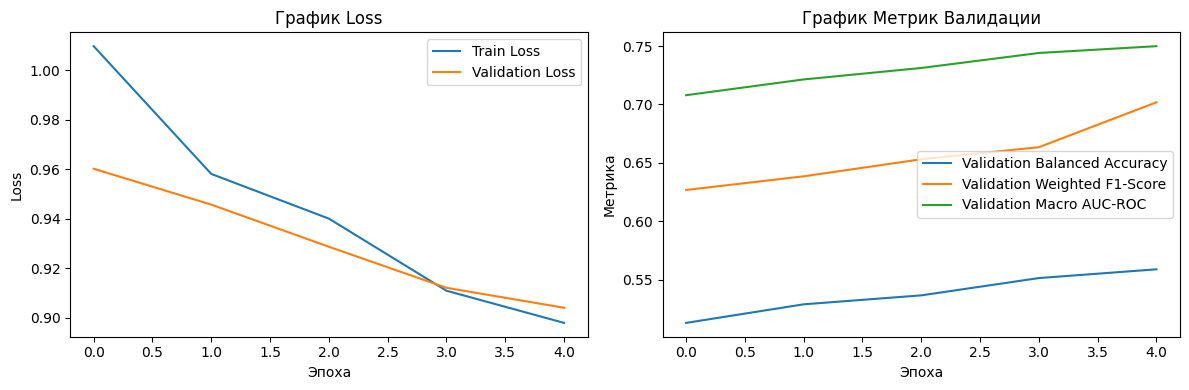

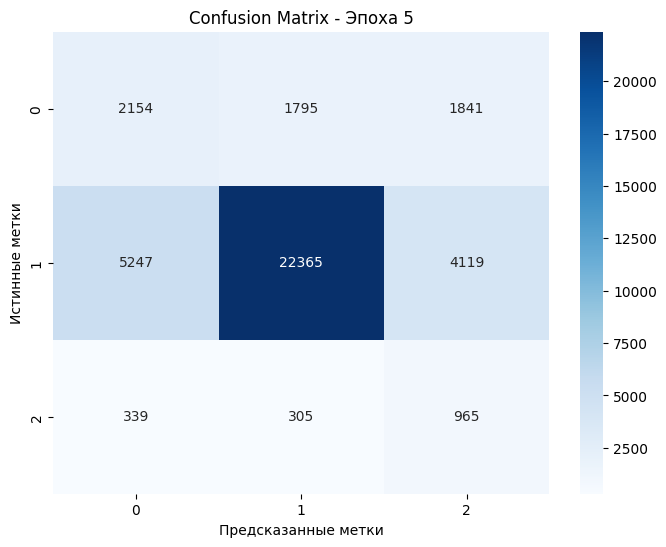

Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.37      0.32      5790
           1       0.91      0.70      0.80     31731
           2       0.14      0.60      0.23      1609

    accuracy                           0.65     39130
   macro avg       0.44      0.56      0.45     39130
weighted avg       0.79      0.65      0.70     39130



Эпоха 6/30 (Валидация): 100%|██████████| 10/10 [00:06<00:00,  1.64it/s, val_loss=0.879]



Эпоха: 6/30
Train Loss: 0.8689
Validation Loss: 0.8920
Validation Balanced Accuracy: 0.5678
Validation Weighted F1-Score: 0.6784
Validation Macro AUC-ROC: 0.7568

Модель улучшена и сохранена! (Validation Loss: 0.8920, Эпоха: 6)



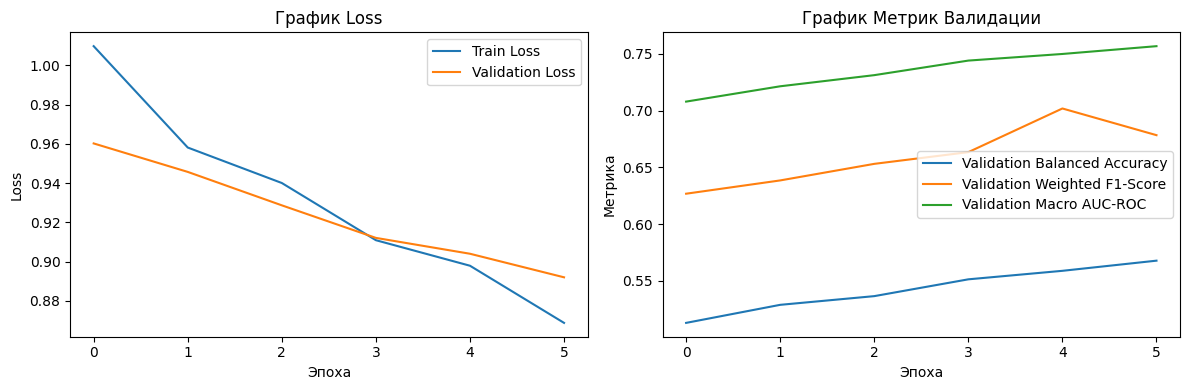

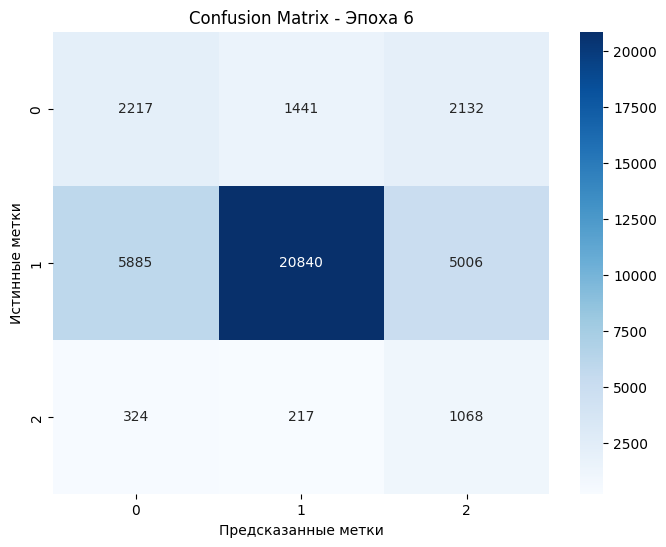

Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.38      0.31      5790
           1       0.93      0.66      0.77     31731
           2       0.13      0.66      0.22      1609

    accuracy                           0.62     39130
   macro avg       0.44      0.57      0.43     39130
weighted avg       0.80      0.62      0.68     39130



Эпоха 7/30 (Валидация): 100%|██████████| 10/10 [00:05<00:00,  1.68it/s, val_loss=0.883]



Эпоха: 7/30
Train Loss: 0.8554
Validation Loss: 0.8875
Validation Balanced Accuracy: 0.5710
Validation Weighted F1-Score: 0.6824
Validation Macro AUC-ROC: 0.7619

Модель улучшена и сохранена! (Validation Loss: 0.8875, Эпоха: 7)



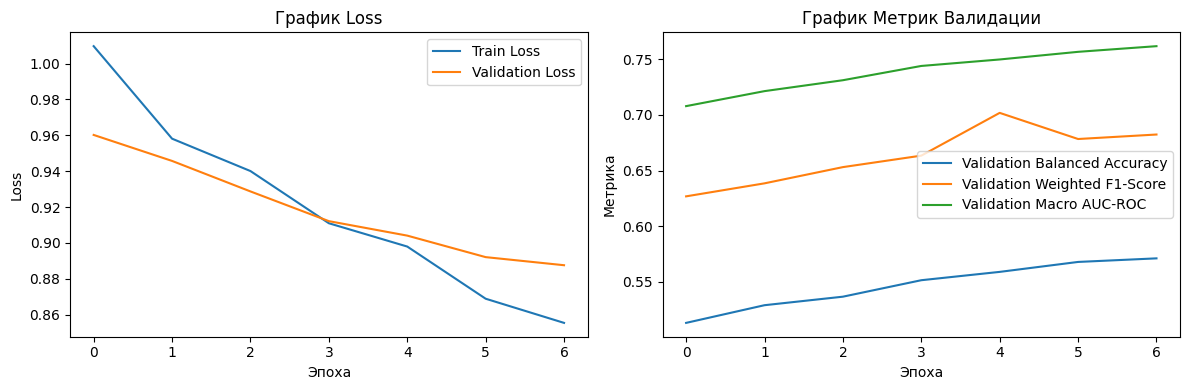

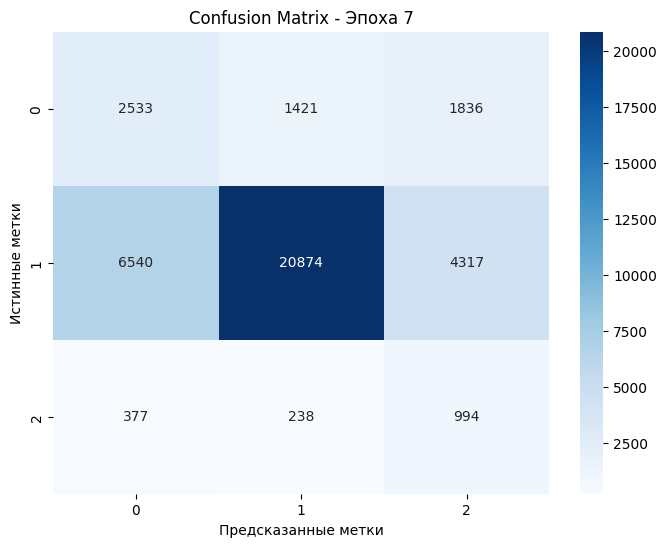

Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.44      0.33      5790
           1       0.93      0.66      0.77     31731
           2       0.14      0.62      0.23      1609

    accuracy                           0.62     39130
   macro avg       0.44      0.57      0.44     39130
weighted avg       0.80      0.62      0.68     39130



Эпоха 8/30 (Валидация): 100%|██████████| 10/10 [00:06<00:00,  1.65it/s, val_loss=0.882]



Эпоха: 8/30
Train Loss: 0.8446
Validation Loss: 0.8866
Validation Balanced Accuracy: 0.5740
Validation Weighted F1-Score: 0.6865
Validation Macro AUC-ROC: 0.7641

Модель улучшена и сохранена! (Validation Loss: 0.8866, Эпоха: 8)



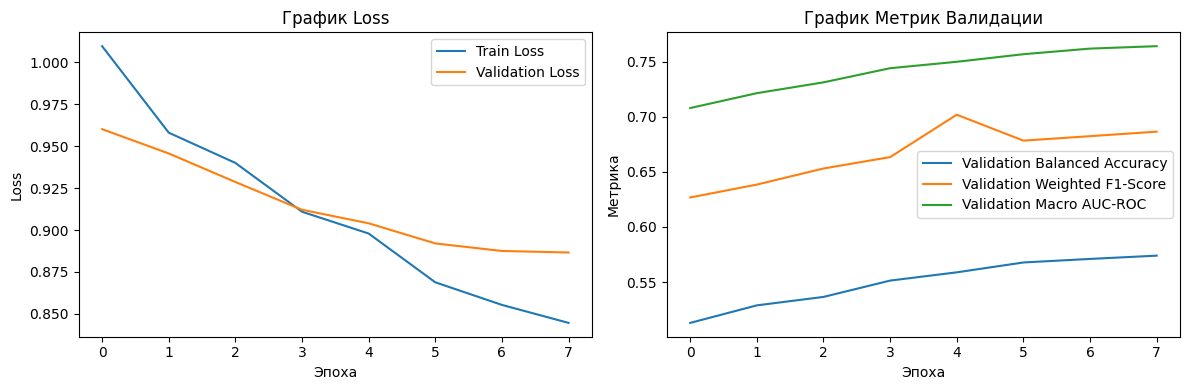

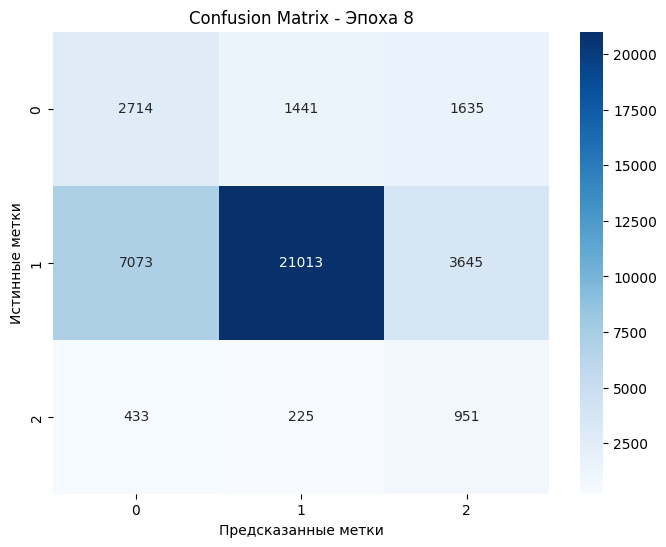

Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.47      0.34      5790
           1       0.93      0.66      0.77     31731
           2       0.15      0.59      0.24      1609

    accuracy                           0.63     39130
   macro avg       0.45      0.57      0.45     39130
weighted avg       0.80      0.63      0.69     39130



Эпоха 9/30 (Валидация): 100%|██████████| 10/10 [00:05<00:00,  1.69it/s, val_loss=0.868]



Эпоха: 9/30
Train Loss: 0.8142
Validation Loss: 0.8814
Validation Balanced Accuracy: 0.5773
Validation Weighted F1-Score: 0.6973
Validation Macro AUC-ROC: 0.7680

Модель улучшена и сохранена! (Validation Loss: 0.8814, Эпоха: 9)



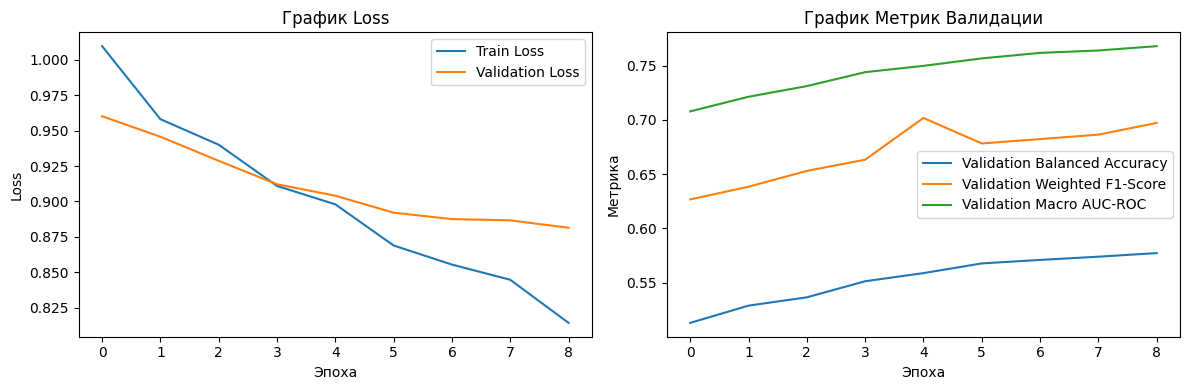

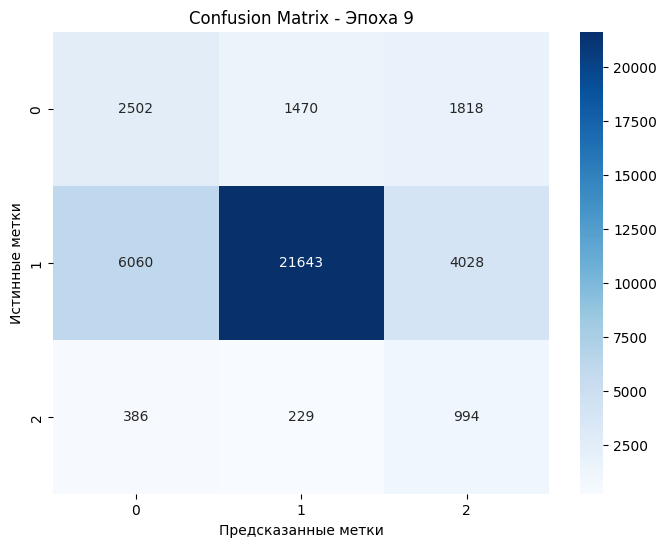

Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.43      0.34      5790
           1       0.93      0.68      0.79     31731
           2       0.15      0.62      0.24      1609

    accuracy                           0.64     39130
   macro avg       0.45      0.58      0.45     39130
weighted avg       0.80      0.64      0.70     39130



Эпоха 10/30 (Валидация): 100%|██████████| 10/10 [00:06<00:00,  1.60it/s, val_loss=0.877]



Эпоха: 10/30
Train Loss: 0.8006
Validation Loss: 0.8838
Validation Balanced Accuracy: 0.5794
Validation Weighted F1-Score: 0.6991
Validation Macro AUC-ROC: 0.7679

Валидационный лосс не улучшился (1/5 эпох)


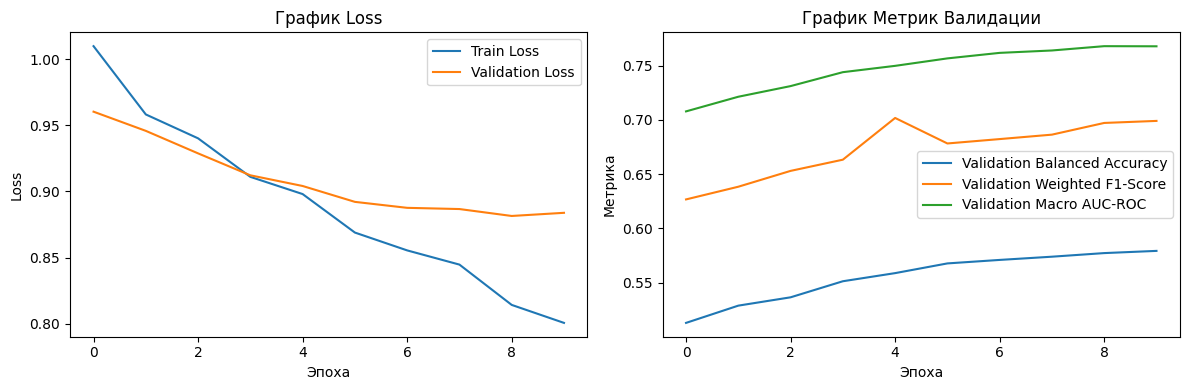

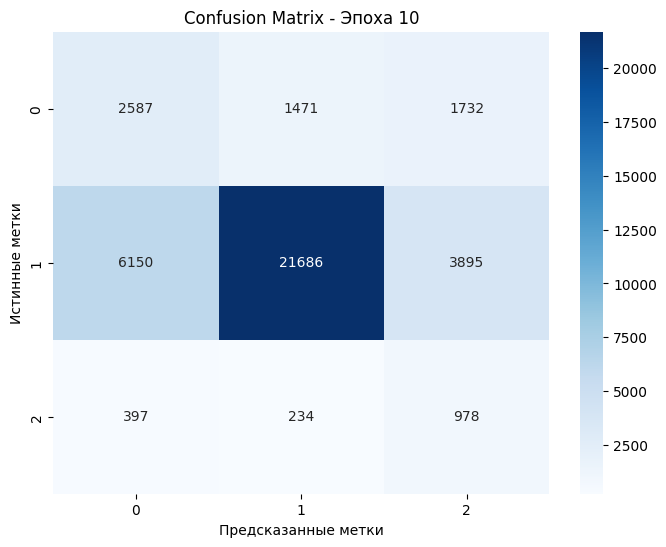

Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.45      0.35      5790
           1       0.93      0.68      0.79     31731
           2       0.15      0.61      0.24      1609

    accuracy                           0.65     39130
   macro avg       0.45      0.58      0.46     39130
weighted avg       0.80      0.65      0.70     39130



Эпоха 11/30 (Валидация): 100%|██████████| 10/10 [00:06<00:00,  1.65it/s, val_loss=0.87]



Эпоха: 11/30
Train Loss: 0.7803
Validation Loss: 0.8797
Validation Balanced Accuracy: 0.5801
Validation Weighted F1-Score: 0.6908
Validation Macro AUC-ROC: 0.7710

Модель улучшена и сохранена! (Validation Loss: 0.8797, Эпоха: 11)



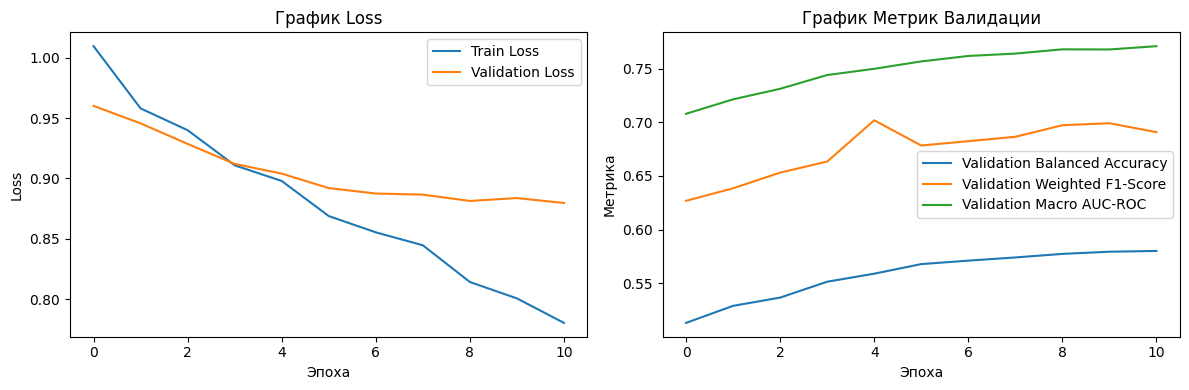

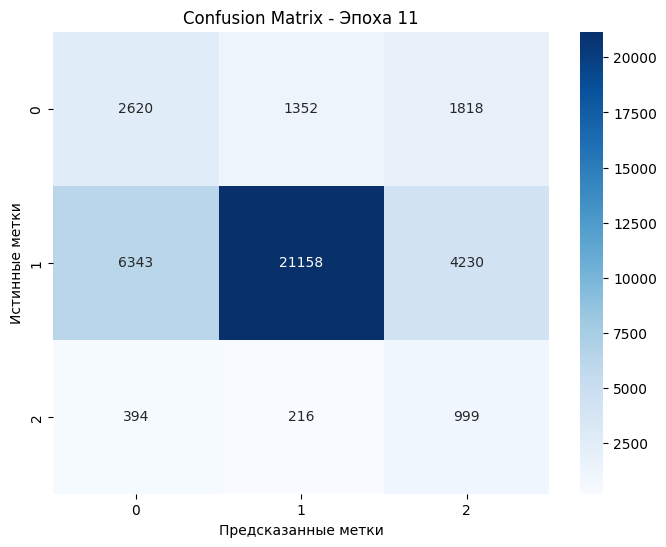

Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.45      0.35      5790
           1       0.93      0.67      0.78     31731
           2       0.14      0.62      0.23      1609

    accuracy                           0.63     39130
   macro avg       0.45      0.58      0.45     39130
weighted avg       0.80      0.63      0.69     39130



Эпоха 12/30 (Валидация): 100%|██████████| 10/10 [00:06<00:00,  1.64it/s, val_loss=0.874]



Эпоха: 12/30
Train Loss: 0.7675
Validation Loss: 0.8875
Validation Balanced Accuracy: 0.5790
Validation Weighted F1-Score: 0.7079
Validation Macro AUC-ROC: 0.7726

Валидационный лосс не улучшился (1/5 эпох)


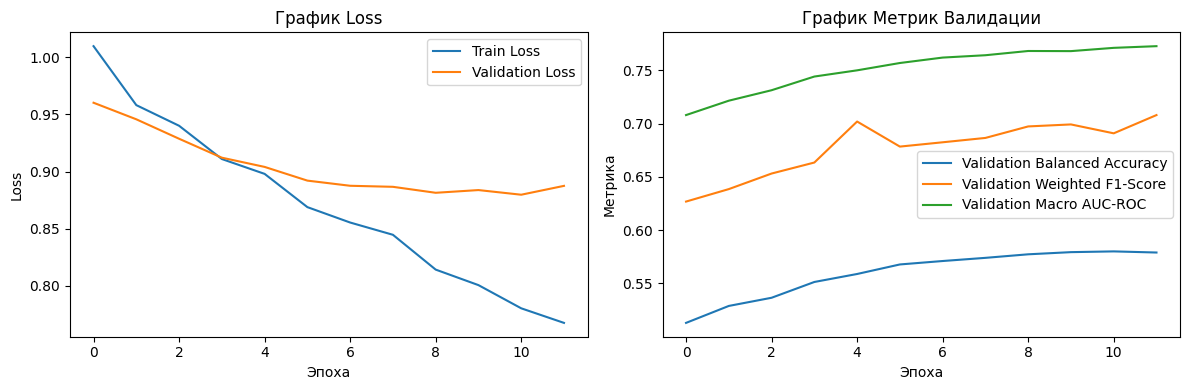

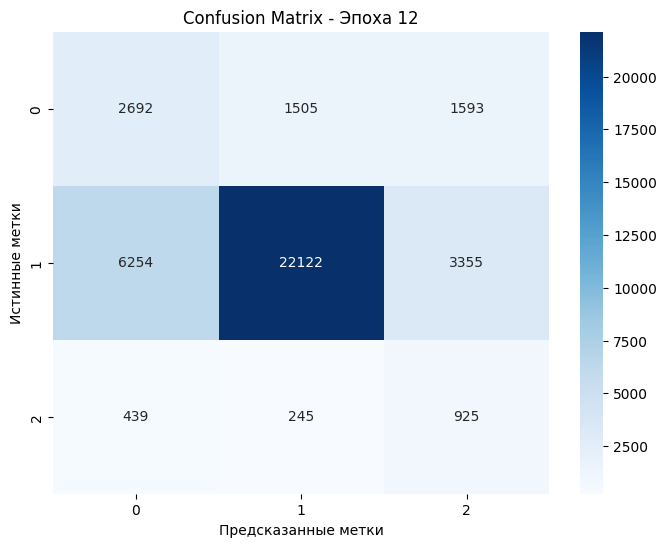

Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.46      0.35      5790
           1       0.93      0.70      0.80     31731
           2       0.16      0.57      0.25      1609

    accuracy                           0.66     39130
   macro avg       0.46      0.58      0.47     39130
weighted avg       0.80      0.66      0.71     39130



Эпоха 13/30 (Валидация): 100%|██████████| 10/10 [00:05<00:00,  1.69it/s, val_loss=0.881]



Эпоха: 13/30
Train Loss: 0.7606
Validation Loss: 0.8914
Validation Balanced Accuracy: 0.5800
Validation Weighted F1-Score: 0.7076
Validation Macro AUC-ROC: 0.7728

Валидационный лосс не улучшился (2/5 эпох)


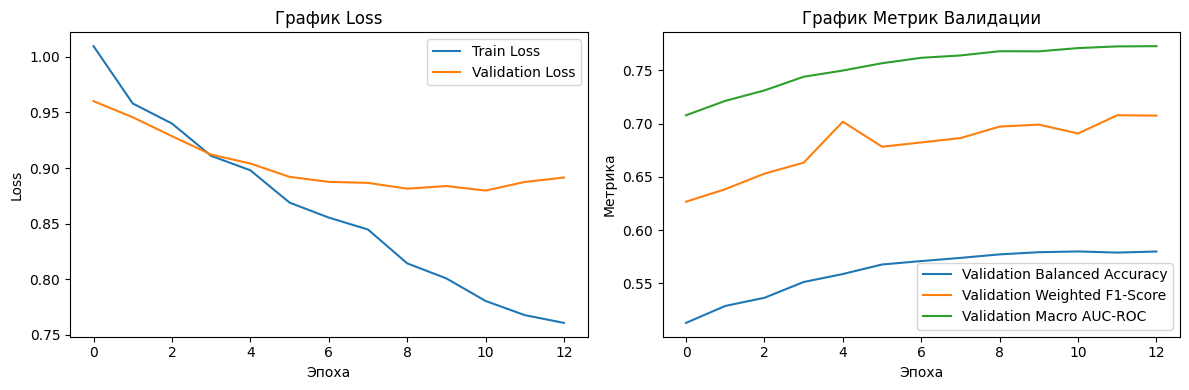

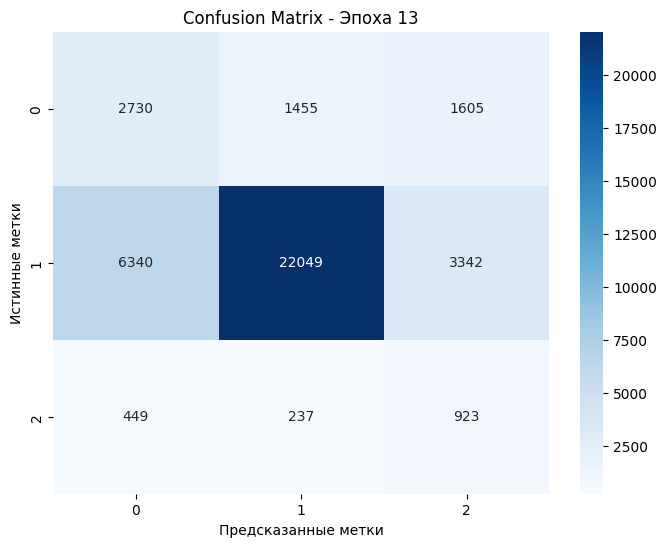

Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.47      0.36      5790
           1       0.93      0.69      0.79     31731
           2       0.16      0.57      0.25      1609

    accuracy                           0.66     39130
   macro avg       0.46      0.58      0.47     39130
weighted avg       0.80      0.66      0.71     39130



Эпоха 14/30 (Валидация): 100%|██████████| 10/10 [00:06<00:00,  1.59it/s, val_loss=0.874]



Эпоха: 14/30
Train Loss: 0.7471
Validation Loss: 0.8901
Validation Balanced Accuracy: 0.5840
Validation Weighted F1-Score: 0.7045
Validation Macro AUC-ROC: 0.7733

Валидационный лосс не улучшился (3/5 эпох)


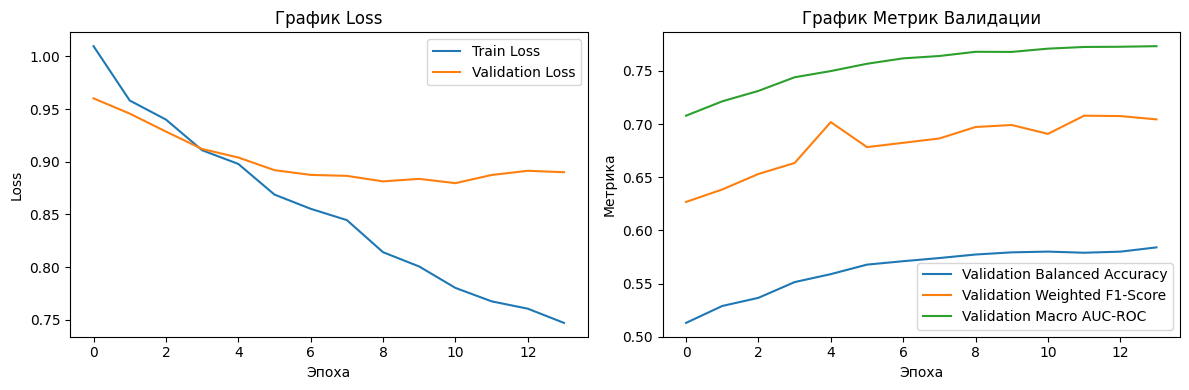

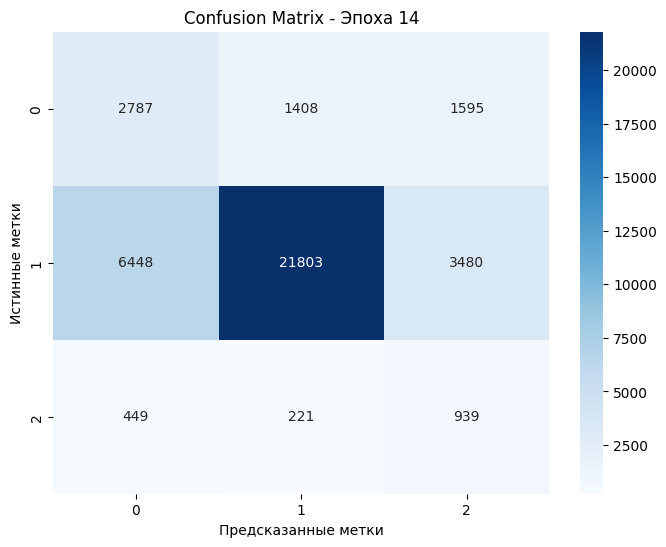

Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.48      0.36      5790
           1       0.93      0.69      0.79     31731
           2       0.16      0.58      0.25      1609

    accuracy                           0.65     39130
   macro avg       0.46      0.58      0.47     39130
weighted avg       0.80      0.65      0.70     39130



Эпоха 15/30 (Валидация): 100%|██████████| 10/10 [00:06<00:00,  1.65it/s, val_loss=0.877]



Эпоха: 15/30
Train Loss: 0.7407
Validation Loss: 0.8964
Validation Balanced Accuracy: 0.5792
Validation Weighted F1-Score: 0.7092
Validation Macro AUC-ROC: 0.7729

Валидационный лосс не улучшился (4/5 эпох)


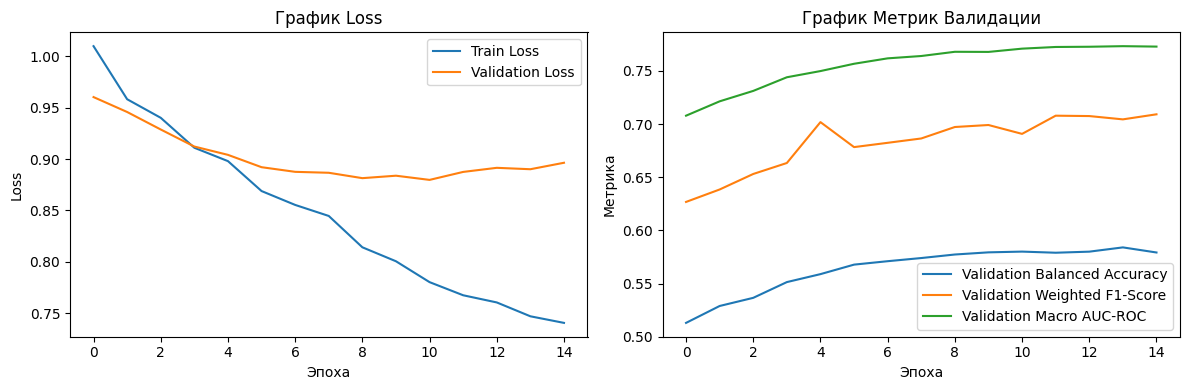

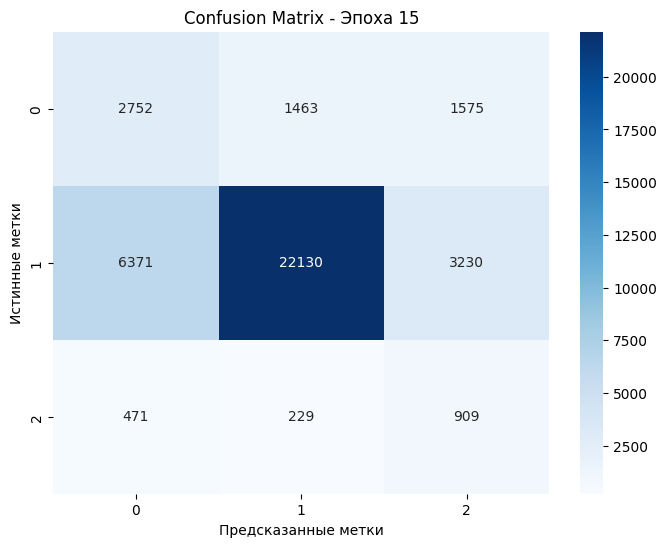

Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.48      0.36      5790
           1       0.93      0.70      0.80     31731
           2       0.16      0.56      0.25      1609

    accuracy                           0.66     39130
   macro avg       0.46      0.58      0.47     39130
weighted avg       0.80      0.66      0.71     39130



Эпоха 16/30 (Валидация): 100%|██████████| 10/10 [00:06<00:00,  1.63it/s, val_loss=0.874]


Эпоха: 16/30
Train Loss: 0.7334
Validation Loss: 0.8950
Validation Balanced Accuracy: 0.5821
Validation Weighted F1-Score: 0.7076
Validation Macro AUC-ROC: 0.7736

Валидационный лосс не улучшился (5/5 эпох)
Ранняя остановка! Валидационный лосс не улучшался в течение 5 эпох.
Обучение завершено!
Лучшая модель сохранена на эпохе: 11 с Validation Loss: 0.8797


In [41]:
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []
val_auc_rocs = []

best_val_loss = float('inf')
best_epoch = 0
patience = 5
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    progress_bar_train = tqdm(enumerate(train_loader),
                              total=len(train_loader),
                              desc=f"Эпоха {epoch+1}/{num_epochs} (Обучение)")
    for i, (categorical_batch, labels_batch, numerical_batch)\
            in progress_bar_train:
        categorical_batch_gpu = {
            name: tensor.to(device)
            for name, tensor in categorical_batch.items()
        }
        labels_batch_gpu = labels_batch.to(device)
        numerical_batch_gpu = numerical_batch.to(device)

        optimizer.zero_grad()
        outputs = model(categorical_batch_gpu, numerical_batch_gpu)
        loss = criterion(outputs, labels_batch_gpu)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)

        progress_bar_train.set_postfix({'loss': loss.item()})

    train_loss_epoch = running_loss / len(train_loader)
    train_losses.append(train_loss_epoch)

    scheduler.step()

    model.eval()
    running_val_loss = 0.0
    all_predictions = []
    all_labels = []
    probabilities = []

    progress_bar_val = tqdm(enumerate(val_loader),
                            total=len(val_loader),
                            desc=f"Эпоха {epoch+1}/{num_epochs} (Валидация)")
    with torch.no_grad():
        for i, (categorical_batch_val, labels_batch_val, numerical_batch_val)\
                in progress_bar_val:
            categorical_batch_val_gpu = {
                name: tensor.to(device)
                for name, tensor in categorical_batch_val.items()
            }
            labels_batch_val_gpu = labels_batch_val.to(device)
            numerical_batch_val_gpu = numerical_batch_val.to(device)

            outputs_val = model(categorical_batch_val_gpu,
                                numerical_batch_val_gpu)
            loss_val = criterion(outputs_val, labels_batch_val_gpu)
            running_val_loss += loss_val.item()

            _, predicted_val = torch.max(outputs_val.data, 1)
            all_predictions.extend(predicted_val.cpu().numpy())
            all_labels.extend(labels_batch_val_gpu.cpu().numpy())
            probabilities.extend(torch.softmax(outputs_val,
                                               dim=1).cpu().numpy())

            progress_bar_val.set_postfix({'val_loss': loss_val.item()})

    val_loss_epoch = running_val_loss / len(val_loader)

    scheduler.step()

    accuracy = balanced_accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    auc_roc = roc_auc_score(all_labels, np.array(probabilities),
                            multi_class='ovo', average='macro')

    val_losses.append(val_loss_epoch)
    val_accuracies.append(accuracy)
    val_f1_scores.append(f1)
    val_auc_rocs.append(auc_roc)

    print(f"\nЭпоха: {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss_epoch:.4f}")
    print(f"Validation Loss: {val_loss_epoch:.4f}")
    print(f'Validation Balanced Accuracy: {accuracy:.4f}')
    print(f'Validation Weighted F1-Score: {f1:.4f}')
    print(f'Validation Macro AUC-ROC: {auc_roc:.4f}\n')

    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Модель улучшена и сохранена! "
              f"(Validation Loss: {best_val_loss:.4f}, Эпоха: {best_epoch})\n")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"Валидационный лосс не улучшился "
              f"({epochs_no_improve}/{patience} эпох)")
        if epochs_no_improve >= patience:
            print(f"Ранняя остановка! Валидационный лосс не улучшался"
                  f" в течение {patience} эпох.")
            break

    plots(train_losses,
          val_losses,
          val_accuracies,
          val_f1_scores,
          val_auc_rocs)

print("Обучение завершено!")
print(f"Лучшая модель сохранена на эпохе: {best_epoch}"
      f" с Validation Loss: {best_val_loss:.4f}")

100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Test Loss: 6.4457
Test Balanced Accuracy: 0.5760
Test Weighted F1-Score: 0.7109
Test Macro AUC-ROC: 0.7658



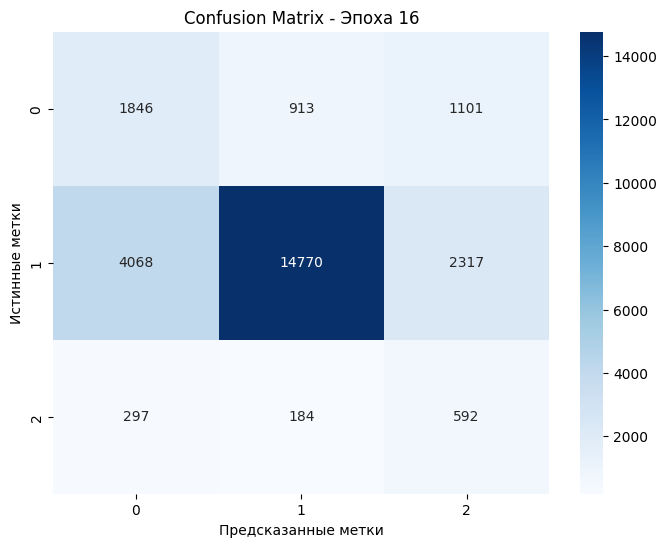

In [42]:
running_test_loss = 0.0
all_predictions = []
all_labels = []
probabilities = []
progress_bar_test = tqdm(enumerate(test_loader), total=len(test_loader))
with torch.no_grad():
    for i, (categorical_batch_test, labels_batch_test, numerical_batch_test)\
            in progress_bar_test:
        categorical_batch_test_gpu = {
            name: tensor.to(device)
            for name, tensor in categorical_batch_test.items()
        }
        labels_batch_test_gpu = labels_batch_test.to(device)
        numerical_batch_test_gpu = numerical_batch_test.to(device)

        outputs_test = model(categorical_batch_test_gpu,
                             numerical_batch_test_gpu)
        loss_test = criterion(outputs_test, labels_batch_test_gpu)
        running_test_loss += loss_test.item()

        _, predicted_test = torch.max(outputs_test.data, 1)
        all_predictions.extend(predicted_test.cpu().numpy())
        all_labels.extend(labels_batch_test_gpu.cpu().numpy())
        probabilities.extend(torch.softmax(outputs_test, dim=1).cpu().numpy())


accuracy = balanced_accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
auc_roc = roc_auc_score(all_labels, np.array(probabilities),
                        multi_class='ovo', average='macro')
print(f"Test Loss: {running_test_loss:.4f}")
print(f'Test Balanced Accuracy: {accuracy:.4f}')
print(f'Test Weighted F1-Score: {f1:.4f}')
print(f'Test Macro AUC-ROC: {auc_roc:.4f}\n')


conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d",
            cmap="Blues",
            xticklabels=np.unique(all_labels),
            yticklabels=np.unique(all_labels))
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')
plt.title(f'Confusion Matrix on Test')
plt.show()


<span style="font-family: 'Times New Roman'; font-size: 18px;">Побить catboost безлайн не удалось, что и не удивительно, поскольку catboost имеет множество эвристик, значительно улучшающих качество и поэтому хорошо подходит для табличных данных из коробки.Как видно из графиков, основной проблемой обучения является переобучение, поэтому для улучшения текущего решения можно рассмотреть:</span>
1. <span style="font-family: 'Times New Roman'; font-size: 17px;">Более тщательный и аккуратный подбор гиперпараметров</span>
2. <span style="font-family: 'Times New Roman'; font-size: 17px;">Дальнейшее изучение данных и построение новых признаков</span>
3. <span style="font-family: 'Times New Roman'; font-size: 17px;">Поиск новых и более совершенных способов борьбы с дисбалансом классов</span>
4. <span style="font-family: 'Times New Roman'; font-size: 17px;">Пересмотр архитектуры модели в пользу более новых моделей, например, [TabNet](https://arxiv.org/pdf/1908.07442v5)</span>